In [1]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import  Activation, Dropout
from tensorflow.keras import layers
from keras.utils import np_utils
import tensorflow_hub as hub
import os
import pickle


In [2]:
plt.rcParams.update({'font.size': 16})

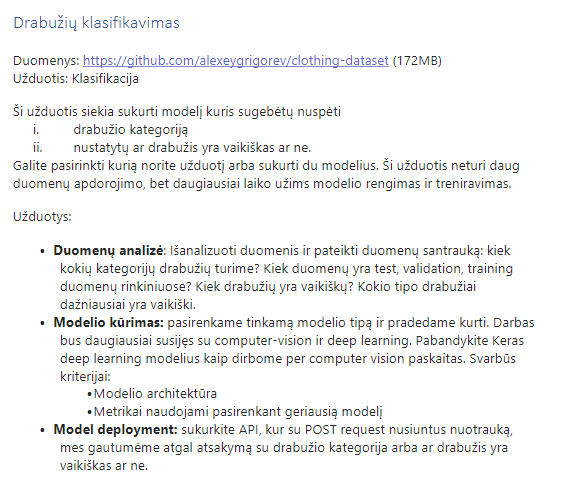

In [3]:
from IPython import display
display.Image("task.png")

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3


In [5]:
# visos funkcijos

def read_and_decode(filename, reshape_dims):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, reshape_dims)


def show_image(filename):
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    plt.imshow((img.numpy()));
    

def multi_images(dataset):
    f, ax = plt.subplots(1, 10, figsize=(15,15))
    for idx, filename in enumerate(dataset["photo"][20:30]):
        img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
        ax[idx].imshow((img.numpy()));
        ax[idx].set_title(dataset["label"][20+idx])
        ax[idx].axis('off')

def decode_csv(csv_row):
    record_defaults = ["photo", "label"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(sar, label_string))
    return img, label


def training_plot_simple(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)
        

def plot_predictions(model, filename):
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    dataset = (tf.data.TextLineDataset(filename).map(decode_csv))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = sar[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = sar[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
        ax[idx//5, idx%5].axis('off')
        
        
def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)

class _Preprocessor:    
    def __init__(self):
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)

# Duomenų analizė

In [6]:
data=pd.read_csv("images.csv")

data["photo"]='images/'+data["image"]+'.jpg'
data

image  sender_id     label   kids  \
0     4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False   
1     ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False   
2     00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False   
3     ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False   
4     3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False   
...                                    ...        ...       ...    ...   
5398  dfd4079d-967b-4b3e-8574-fbac11b58103        204    Shorts  False   
5399  befa14be-8140-4faf-8061-1039947e329d        204      Body   True   
5400  5379356a-40ee-4890-b416-2336a7d84061        310    Shorts  False   
5401  65507fb8-3456-4c15-b53e-d1b03bf71a59        204     Shoes  False   
5402  32b99302-cec7-4dec-adfa-3d4029674209        204     Skirt  False   

                                                photo  
0     images/4285fab0-751a-4b74-8e9b-43af05deee22.jpg  
1     images/ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg  
2     images/00627a3f-0477-401c-95eb-92642cbe078d.jpg  
3     images/ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg  
4     images/3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg  
...                                               ...  
5398  images/dfd4079d-967b-4b3e-8574-fbac11b58103.jpg  
5399  images/befa14be-8140-4faf-8061-1039947e329d.jpg  
5400  images/5379356a-40ee-4890-b416-2336a7d84061.jpg  
5401  images/65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg  
5402  images/32b99302-cec7-4dec-adfa-3d4029674209.jpg  

[5403 rows x 5 columns]

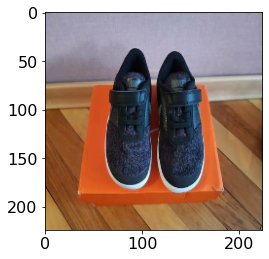

In [7]:
show_image("images/0bacb2c4-3d90-4835-b23e-aa7c2284d1bc.jpg")

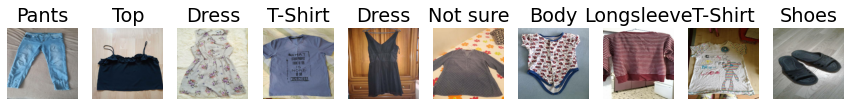

In [8]:
multi_images(data)

In [9]:
data.label.value_counts() 

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

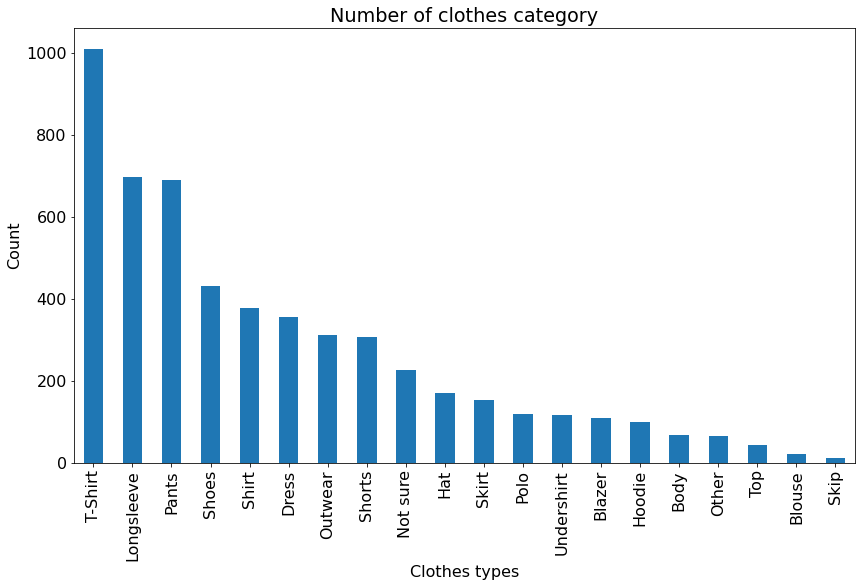

In [62]:
ax = data['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of clothes category")
ax.set_xlabel("Clothes types")
ax.set_ylabel("Count");

#### Yra 20 drabužių kategorijų. Daugiausia yra marškinėlių, marškinėliu ilgomis rankovėmis ir kelnių drabužių. Yra Not sure kategorija ir Skip, kurios kelias daugiau klausimų. Pastebėjau, kad tarp Skip kategorijos drabužių buvo tokių eilučių su failu pavadinimu, kokių nuotraukų nebuvo images folderyje. 

#### Tarp nuotraukų yra 228 drabužiai, kurie yra suklasifikuoti, kaip Not sure. Pažiūrėsiu, kaip jie atrodo.

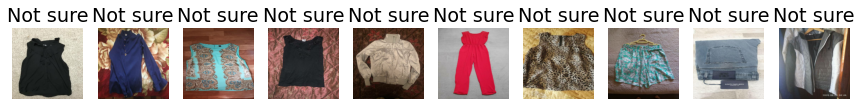

In [10]:
not_sure=data[data.label=="Not sure"].reset_index()

multi_images(not_sure)

####  Not Sure kategorijos drabužiai daugiausia yra marškinėliai, ir ilgomis rankovėmis maiškinėliai, taip pat ir yra ir kitų kategorijų drabužių, kaip kombinezonų, šortų ir panašiai

In [12]:
data.kids.value_counts()

False    4927
True      476
Name: kids, dtype: int64

#### Yra 476 vaikiški drabužiai ir 4927 nevaikiški pradiniame duomenų rinkinyje, bet ši informacija bus neaktuali tolimesniuose žingsniuose

Kadangi Not sure kategorija yra su skirtingais drabužiai, o Skip kategorijoje trūksta failų, tai aš pašalinsiu jas.

In [13]:
data_new=data[data.label!="Not sure"] # Not sure reiksmes pasalinu
data_new=data_new[data_new.label!="Skip"] # Skip reiksmes pasalinu

In [14]:
data_new

image  sender_id    label   kids  \
1     ea7b6656-3f84-4eb3-9099-23e623fc1018        148  T-Shirt  False   
3     ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43  T-Shirt  False   
4     3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189    Shoes  False   
5     5d3a1404-697f-479f-9090-c1ecd0413d27        138   Shorts  False   
6     b0c03127-9dfb-4573-8934-1958396937bf        138    Shirt  False   
...                                    ...        ...      ...    ...   
5398  dfd4079d-967b-4b3e-8574-fbac11b58103        204   Shorts  False   
5399  befa14be-8140-4faf-8061-1039947e329d        204     Body   True   
5400  5379356a-40ee-4890-b416-2336a7d84061        310   Shorts  False   
5401  65507fb8-3456-4c15-b53e-d1b03bf71a59        204    Shoes  False   
5402  32b99302-cec7-4dec-adfa-3d4029674209        204    Skirt  False   

                                                photo  
1     images/ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg  
3     images/ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg  
4     images/3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg  
5     images/5d3a1404-697f-479f-9090-c1ecd0413d27.jpg  
6     images/b0c03127-9dfb-4573-8934-1958396937bf.jpg  
...                                               ...  
5398  images/dfd4079d-967b-4b3e-8574-fbac11b58103.jpg  
5399  images/befa14be-8140-4faf-8061-1039947e329d.jpg  
5400  images/5379356a-40ee-4890-b416-2336a7d84061.jpg  
5401  images/65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg  
5402  images/32b99302-cec7-4dec-adfa-3d4029674209.jpg  

[5163 rows x 5 columns]

#### Patikrisiu ar visi išvardinti nuotraukų failai yra images folderyje. 

In [15]:
yra=[]
for index,file in enumerate(data_new["photo"]):
    yra.append(os.path.exists(file))


In [16]:
yra.count(False) #visi failai yra, viskas gerai

0

#### Pašalinus Skip kategoriją, dabar yra visi failai, kurie yra data_new išvardinti.

#### Patikrinama Other drabužių kategorija

In [18]:
kita=data_new[data_new.label=="Other"]
kita=kita.reset_index()

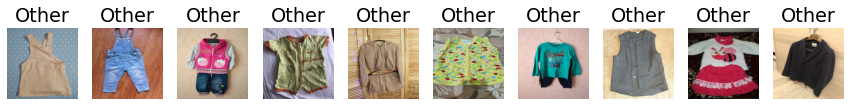

In [19]:
multi_images(kita)

#### Other kategoriją irgi pašalinsiu, nes joje yra ivairių drabužių: švarkų, pirštinių, kostiumėlių, kombinezonų ir kitų.

In [20]:
data_new=data_new[data_new.label!="Other"]
data_new.reset_index(inplace=True)

In [21]:
data_new.label.value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Top             43
Blouse          23
Name: label, dtype: int64

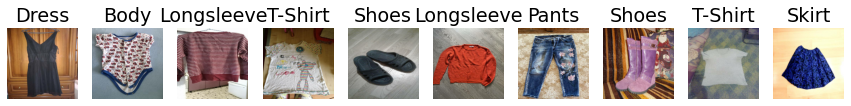

In [22]:
multi_images(data_new)

#### Dabar atrodo, kad duomenys yra jau sutvarkyti, visos drabužių kategorijos yra aiškios, apimančios tik vietą tam tikrą drabužį.

# Atrenku 5 didžiausias kategorijas tolimesniems žingsniams ir modelio kūrimui

In [23]:
sar=["T-Shirt", "Longsleeve", "Pants", "Shoes", "Shirt"] 


In [24]:
small_data=data_new.loc[data_new.label.isin(sar)]
small_data.reset_index(inplace=True)
small_data #yra 3211 eiluciu

level_0  index                                 image  sender_id  \
0           0      1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148   
1           1      3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   
2           2      4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189   
3           4      6  b0c03127-9dfb-4573-8934-1958396937bf        138   
4           5      7  4c8f245e-a039-46fd-a6b9-1bb51e83fc05        226   
...       ...    ...                                   ...        ...   
3206     5085   5392  29cffc8e-5e72-4b73-bbc0-20b9f1251bc2        204   
3207     5087   5394  575fc7c5-aa65-46c6-a343-35113c150129        310   
3208     5088   5395  acf7a391-8450-453d-898b-2a4a9d2886f6        204   
3209     5090   5397  3855ea22-5e7f-411f-b1fa-6db27a676c06        204   
3210     5094   5401  65507fb8-3456-4c15-b53e-d1b03bf71a59        204   

           label   kids                                            photo  
0        T-Shirt  False  images/ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg  
1        T-Shirt  False  images/ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg  
2          Shoes  False  images/3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg  
3          Shirt  False  images/b0c03127-9dfb-4573-8934-1958396937bf.jpg  
4        T-Shirt  False  images/4c8f245e-a039-46fd-a6b9-1bb51e83fc05.jpg  
...          ...    ...                                              ...  
3206     T-Shirt  False  images/29cffc8e-5e72-4b73-bbc0-20b9f1251bc2.jpg  
3207       Shirt  False  images/575fc7c5-aa65-46c6-a343-35113c150129.jpg  
3208  Longsleeve  False  images/acf7a391-8450-453d-898b-2a4a9d2886f6.jpg  
3209       Shoes   True  images/3855ea22-5e7f-411f-b1fa-6db27a676c06.jpg  
3210       Shoes  False  images/65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg  

[3211 rows x 7 columns]

In [25]:
sd=small_data[["photo", "label"]] #paliekami tik photo ir label stulpeliai
sd

photo       label
0     images/ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg     T-Shirt
1     images/ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg     T-Shirt
2     images/3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg       Shoes
3     images/b0c03127-9dfb-4573-8934-1958396937bf.jpg       Shirt
4     images/4c8f245e-a039-46fd-a6b9-1bb51e83fc05.jpg     T-Shirt
...                                               ...         ...
3206  images/29cffc8e-5e72-4b73-bbc0-20b9f1251bc2.jpg     T-Shirt
3207  images/575fc7c5-aa65-46c6-a343-35113c150129.jpg       Shirt
3208  images/acf7a391-8450-453d-898b-2a4a9d2886f6.jpg  Longsleeve
3209  images/3855ea22-5e7f-411f-b1fa-6db27a676c06.jpg       Shoes
3210  images/65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg       Shoes

[3211 rows x 2 columns]

In [26]:
train, test = train_test_split(sd, test_size=0.2, random_state=100)

In [27]:
train

photo       label
2213  images/ae7ec1a1-47e3-4ff4-af90-50fa4bef4d4e.jpg     T-Shirt
937   images/b8c71b29-9989-4d27-8274-cdb9a813a6d5.jpg  Longsleeve
2479  images/5ca1e689-1dae-48c3-9b8b-b47a3365cc01.jpg  Longsleeve
1639  images/9760ea86-277b-4291-be10-03141e3b1ecb.jpg       Pants
168   images/ef4afaa2-ce6f-4063-83ad-beac8d201e67.jpg       Shirt
...                                               ...         ...
1930  images/fe7ca6a3-50a8-4377-9e67-a80652d1594a.jpg       Shirt
79    images/2fb12663-3f0a-407f-8bdf-e366d62d459a.jpg     T-Shirt
1859  images/e7ec7ab5-494f-417c-a0ce-c7bbef93d745.jpg       Shirt
2840  images/d1ee3196-3069-4bd9-8a36-507bc2302d14.jpg  Longsleeve
1544  images/626ea40f-13c8-464a-aa44-eb9b9c1ef5c9.jpg     T-Shirt

[2568 rows x 2 columns]

In [28]:
train.to_csv('train.csv', index=False, header=False) # issaugau nauja csv faila, kad paskui galeciau ta dataset naudoti modeliui
test.to_csv('test.csv', index=False, header=False)

In [29]:
train_dataset = (tf.data.TextLineDataset(
    "train.csv").map(decode_csv)).batch(10)

test_dataset = (tf.data.TextLineDataset(
    "test.csv").map(decode_csv)).batch(10)

# Modelio kūrimas

Patikrinu ar test_dataset ir train_dataset gerai susikūrė, ar yra nuskaitomi duomenys iš sukurtų failų.

In [63]:
for img, label in test_dataset.take(1):
    print("Veikia") 

img[0]

Veikia


<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.27879372, 0.22781333, 0.20428392],
        [0.2663675 , 0.2153871 , 0.1918577 ],
        [0.28832254, 0.23734213, 0.21381272],
        ...,
        [0.47086832, 0.4784314 , 0.47436982],
        [0.48487383, 0.48487383, 0.4770307 ],
        [0.45318276, 0.45318276, 0.44533962]],

       [[0.29003856, 0.23905814, 0.21552873],
        [0.27548146, 0.22450107, 0.20097166],
        [0.2938288 , 0.24284841, 0.219319  ],
        ...,
        [0.47505155, 0.48261464, 0.47855306],
        [0.48579708, 0.48579708, 0.47795394],
        [0.45419285, 0.45419285, 0.4463497 ]],

       [[0.30301997, 0.25203958, 0.22851017],
        [0.28803396, 0.23705359, 0.21352418],
        [0.2993785 , 0.24839813, 0.22486871],
        ...,
        [0.48040807, 0.4879712 , 0.48390958],
        [0.490941  , 0.490941  , 0.48309785],
        [0.4596025 , 0.4596025 , 0.45175937]],

       ...,

       [[0.45114657, 0.40799236, 0.37401107],
        [0.43

## Tiesinis modelis

#### Pradedu nuo paprasčiausio modelio - tiesinio. Visi paveikslėlio pixeliai yra ištiesiami į vieną eilutę su daug stulpelių: n x  224 x 224 x 3 -> n x 150528. Tada 150528 stulpeliai suspaudžiami į 5, nes yra 5 atrinktos drabužių kategorijos

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
257/257 [==============================] - 10s 38ms/step - loss: 19.5213 - accuracy: 0.3641 - val_loss: 20.1120 - val_accuracy: 0.4137
Epoch 2/10
257/257 [==============================] - 9s 35ms/step - loss: 12.5639 - accuracy: 0.4467 - val_loss: 16.3483 - val_accuracy: 0.5101
Epoch 3/10
257/257 [==============================] - 7s 28ms/step - loss: 13.8765 - accuracy: 0.4836 - val_loss: 13.0183 - val_accuracy: 0.5179
Epoch 4/10

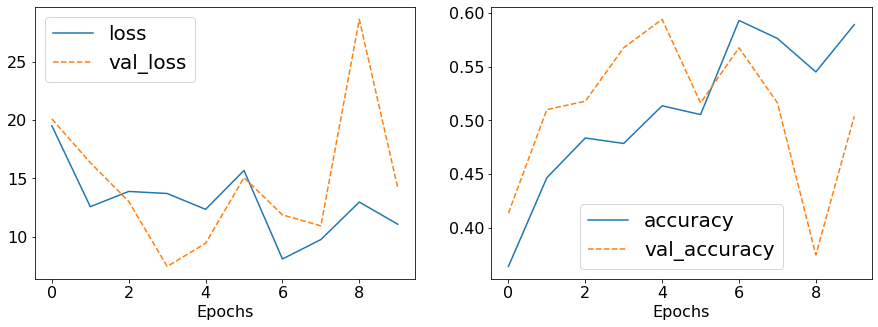

In [31]:
model_linear = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(5, activation='softmax')
])
model_linear.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_linear.summary()

history = model_linear.fit(train_dataset, validation_data=test_dataset, epochs=10)

training_plot_simple(['loss', 'accuracy'], history);

#### Įvertinus tiesinį modelį, iš grafikų matosi, kad visos kreivės yra svyruojančios. Validation_accuracy ir validation_loss kreivės labai svyruoja ir tai rodo, kad modelis nėra geras. Atrodo, kad gal ir būtų treniruojanmies duomenims geras modelis, nes su kiekviena epocha Loss kreivė mažėja, o Accuracy didėja, bet šis trendas yra netolygus. Vertinant vidurkį, modelio vidutinis tikslumas būtų maždaug apie 50%, tai rodo, kad modelio prognozė nėra tiesiog atsitiktinė, bet ir nėra labai gera. Pabandysiu modelį pagerinti.

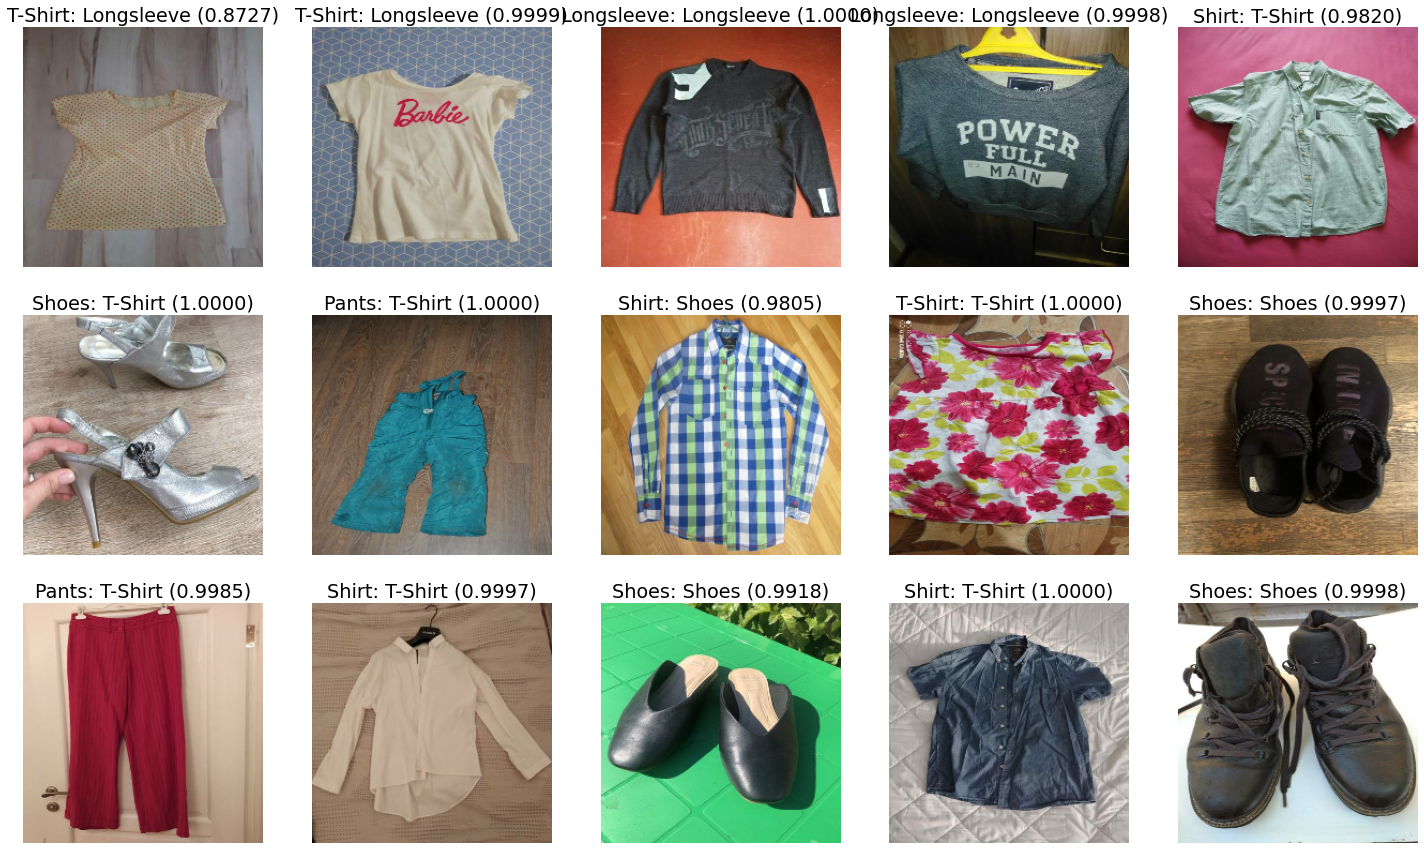

In [32]:
plot_predictions(model_linear, "test.csv")

####  Žiūrint, kiekvienos nuotraukos prognozę atskirai, bent jau šiuo atveju,  dalis nuotraukų sutampa (6  nuotraukos), o dalis ne (9 nuotraukos). Daugiau vis tiek yra neteisingų prognozavimų.

## Pridedu vieną paslėptą sluoksnį modeliui, kuriame 150528  reikšmės susispaudžia į ->  64 reikšmės -> 5 (drabužių kategorijų skaičius)         
                                                                 

Epoch 1/10
257/257 [==============================] - 17s 65ms/step - loss: 9.4712 - accuracy: 0.3030 - val_loss: 1.6038 - val_accuracy: 0.3344
Epoch 2/10
257/257 [==============================] - 16s 64ms/step - loss: 1.5923 - accuracy: 0.3100 - val_loss: 1.5823 - val_accuracy: 0.3344
Epoch 3/10
257/257 [==============================] - 20s 78ms/step - loss: 1.5741 - accuracy: 0.3100 - val_loss: 1.5675 - val_accuracy: 0.3344
Epoch 4/10
257/257 [==============================] - 18s 69ms/step - loss: 1.5625 - accuracy: 0.3100 - val_loss: 1.5585 - val_accuracy: 0.3344
Epoch 5/10
257/257 [==============================] - 19s 74ms/step - loss: 1.5557 - accuracy: 0.3100 - val_loss: 1.5535 - val_accuracy: 0.3344
Epoch 6/10
257/257 [==============================] - 17s 65ms/step - loss: 1.5520 - accuracy: 0.3100 - val_loss: 1.5509 - val_accuracy: 0.3344
Epoch 7/10
257/257 [==============================] - 18s 69ms/step - loss: 1.5501 - accuracy: 0.3100 - val_loss: 1.5496 - val_accuracy:

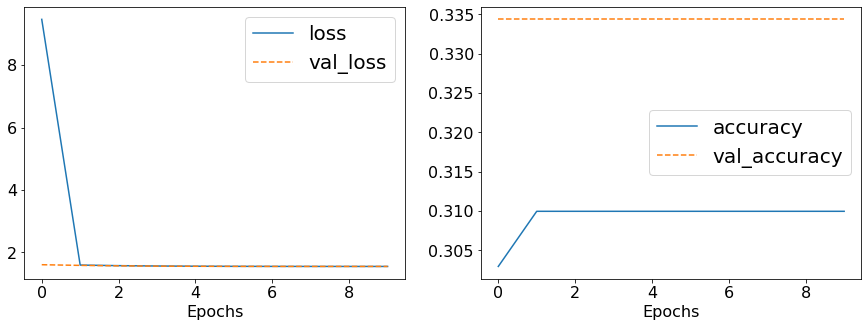

In [33]:
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(sar), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

training_plot_simple(['loss', 'accuracy'], history)

#### Modelis su vienu paslėptu sluoksniu dar blogiau prognozuoja, o validation_accuracy žymiai blogesnis, nei tiesinio modelio. Po 1 epochos jau niekas nebesikeičia.

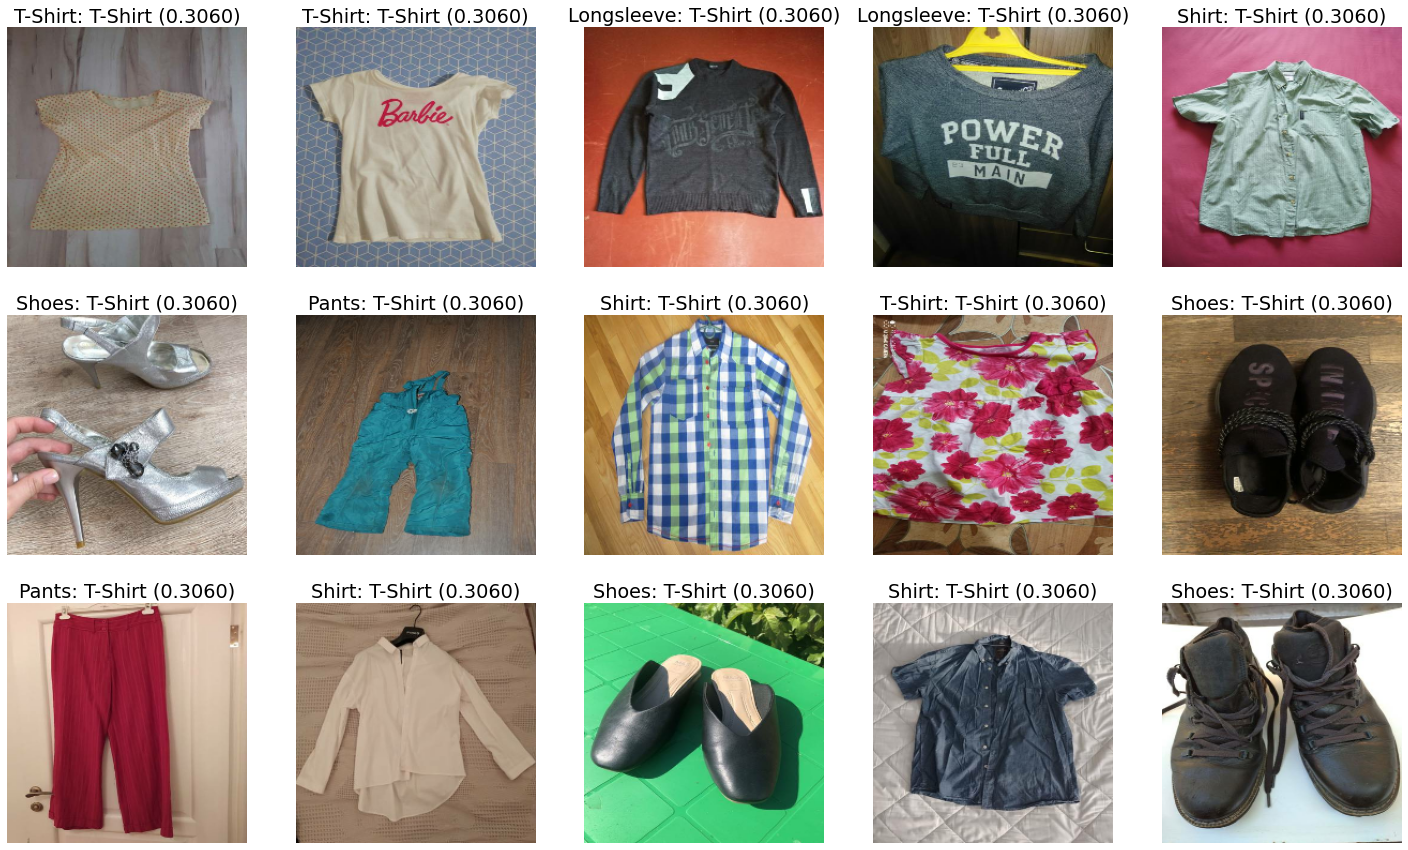

In [34]:
plot_predictions(model, "test.csv")

#### Modelis prognozuoja, kad visi drabužiai yra T-shirt, nes jų duomenyse yra daugiausia.

## Modelis papildomas regularizeriais, pridedamas learning_rate

In [35]:
def train_and_evaluate(lrate = 0.0001, 
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

# NN with one hidden layers
    model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(sar), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)
    training_plot_simple(['loss', 'accuracy'], history)
    return model

Epoch 1/10
257/257 [==============================] - 32s 122ms/step - loss: 2.0570 - accuracy: 0.4030 - val_loss: 1.6732 - val_accuracy: 0.4463
Epoch 2/10
257/257 [==============================] - 28s 110ms/step - loss: 1.3955 - accuracy: 0.5031 - val_loss: 2.1148 - val_accuracy: 0.4230
Epoch 3/10
257/257 [==============================] - 27s 106ms/step - loss: 1.3774 - accuracy: 0.5261 - val_loss: 1.5640 - val_accuracy: 0.5132
Epoch 4/10
257/257 [==============================] - 28s 109ms/step - loss: 1.3057 - accuracy: 0.5389 - val_loss: 1.8443 - val_accuracy: 0.4541
Epoch 5/10
257/257 [==============================] - 28s 109ms/step - loss: 1.2531 - accuracy: 0.5611 - val_loss: 1.7917 - val_accuracy: 0.4510
Epoch 6/10
257/257 [==============================] - 26s 102ms/step - loss: 1.2076 - accuracy: 0.5802 - val_loss: 1.3549 - val_accuracy: 0.5443
Epoch 7/10
257/257 [==============================] - 23s 91ms/step - loss: 1.1094 - accuracy: 0.5974 - val_loss: 1.3045 - val_acc

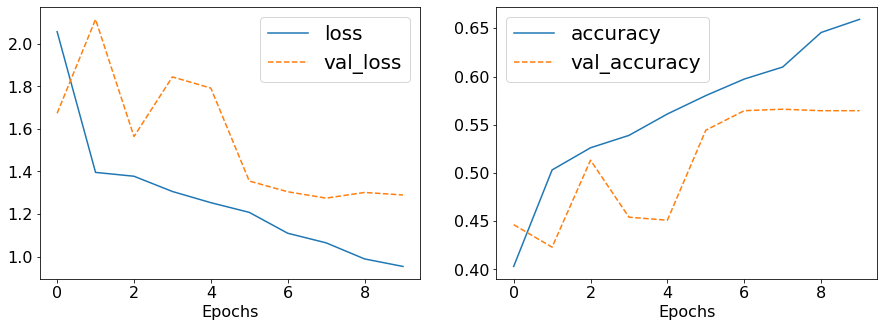

In [36]:
model = train_and_evaluate()

#### Pagerinus modelį rezultatai pastebimai pagerėjo, nebėra tokio didelio šokinėjimo su naujais duomenimis.  Val_accuracy ir Val_loss kreivės turi tokį patį trendą, kaip ir treniruojami duomenys, nors svyravimai vis tiek yra.Tačiau nuo 7 epochos  (6 grafike) parametrai beveik nebesikeičia. 

### Pabandysiu pridėti nebe nulines regularizer reikšmes, pažiūrėsiu ar tai kažką pakeis, taip pat padidinau šiek tiek learning rate.

Epoch 1/10
257/257 [==============================] - 48s 184ms/step - loss: 9.6180 - accuracy: 0.3633 - val_loss: 6.7396 - val_accuracy: 0.3686
Epoch 2/10
257/257 [==============================] - 44s 172ms/step - loss: 7.2640 - accuracy: 0.4077 - val_loss: 7.3039 - val_accuracy: 0.5163
Epoch 3/10
257/257 [==============================] - 45s 175ms/step - loss: 5.4176 - accuracy: 0.4778 - val_loss: 5.4248 - val_accuracy: 0.4914
Epoch 4/10
257/257 [==============================] - 44s 170ms/step - loss: 5.2301 - accuracy: 0.4778 - val_loss: 4.2231 - val_accuracy: 0.4448
Epoch 5/10
257/257 [==============================] - 44s 171ms/step - loss: 3.6158 - accuracy: 0.4914 - val_loss: 3.3007 - val_accuracy: 0.5117
Epoch 6/10
257/257 [==============================] - 44s 170ms/step - loss: 3.2288 - accuracy: 0.4770 - val_loss: 2.7902 - val_accuracy: 0.3904
Epoch 7/10
257/257 [==============================] - 49s 190ms/step - loss: 2.6321 - accuracy: 0.4463 - val_loss: 6.2660 - val_ac

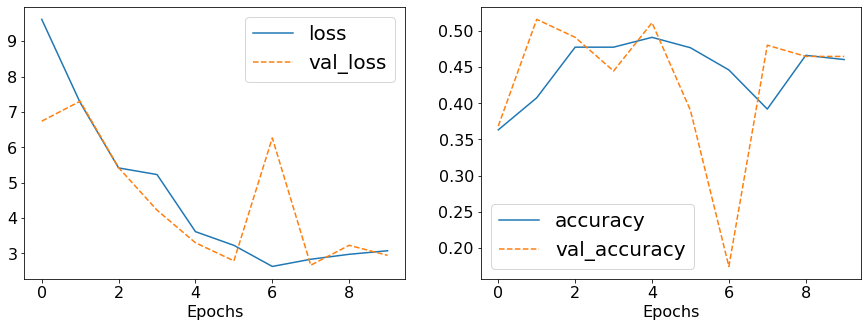

In [37]:
model_regul = train_and_evaluate( lrate=0.0005, l1=0.0001, l2=0, num_hidden=128)

Epoch 1/10
257/257 [==============================] - 47s 179ms/step - loss: 11.6340 - accuracy: 0.3625 - val_loss: 12.7180 - val_accuracy: 0.3468
Epoch 2/10
257/257 [==============================] - 46s 179ms/step - loss: 7.8036 - accuracy: 0.4338 - val_loss: 4.2380 - val_accuracy: 0.4495
Epoch 3/10
257/257 [==============================] - 47s 181ms/step - loss: 4.6555 - accuracy: 0.4774 - val_loss: 7.0448 - val_accuracy: 0.4417
Epoch 4/10
257/257 [==============================] - 46s 181ms/step - loss: 3.3427 - accuracy: 0.5113 - val_loss: 2.3362 - val_accuracy: 0.4852
Epoch 5/10
257/257 [==============================] - 47s 183ms/step - loss: 2.1438 - accuracy: 0.5374 - val_loss: 3.1885 - val_accuracy: 0.4977
Epoch 6/10
257/257 [==============================] - 45s 176ms/step - loss: 1.6174 - accuracy: 0.5607 - val_loss: 1.4046 - val_accuracy: 0.5583
Epoch 7/10
257/257 [==============================] - 45s 176ms/step - loss: 1.4758 - accuracy: 0.4291 - val_loss: 1.3691 - val_

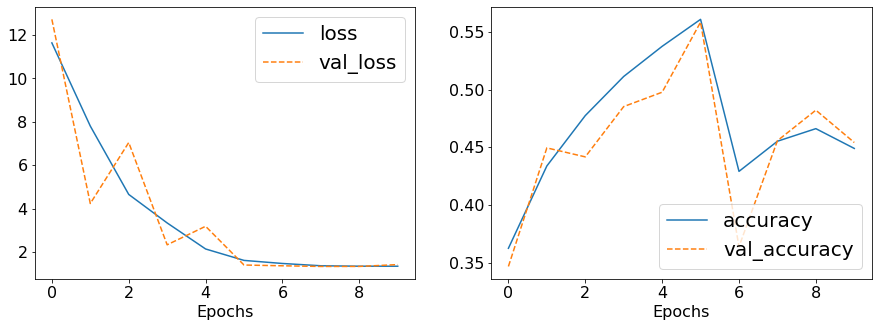

In [38]:
model_regul2 = train_and_evaluate( lrate=0.0005, l1=0, l2=0.0001, num_hidden=128)

#### Na geresnis modelis gavosi, kai abu L1 ir L2 parametrai 0 buvo. Pakeitus L1 ir L2 reikšmes, tiek 7-8 epocha abiejuose variantuose Accuracy kreivė stipriai sumažėja, o Val_accuracy dar staigiau pakrenta. Šie variantai netinka.

## Modelis papildomas taip, kad būtų galima kelis paslėptus sluoksnius įtraukti.

In [39]:

def train_and_evaluate_multihidden(lrate = 0.0001,
                       l1 = 0,
                       l2 = 0,
                       num_hidden = [256, 64]):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)


  # NN with multiple hidden layers
    layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
    layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
    ]
    layers = layers + [
        tf.keras.layers.Dense(len(sar), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='clothes_prob')
  ]

    model = tf.keras.Sequential(layers, name='clothes_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False), metrics=['accuracy'])
    print(model.summary())
    
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)
    
    training_plot_simple(['loss', 'accuracy'], history)
    return model


Model: "clothes_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_pixels (Flatten)      (None, 150528)            0         
                                                                 
 hidden_dense_0 (Dense)      (None, 256)               38535424  
                                                                 
 hidden_dense_1 (Dense)      (None, 64)                16448     
                                                                 
 clothes_prob (Dense)        (None, 5)                 325       
                                                                 
Total params: 38,552,197
Trainable params: 38,552,197
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
257/257 [==============================] - 41s 157ms/step - loss: 1.8388 - accuracy: 0.4147 - val_loss: 1.6484 - val_accuracy: 0.4339
Epoch 2/10
257

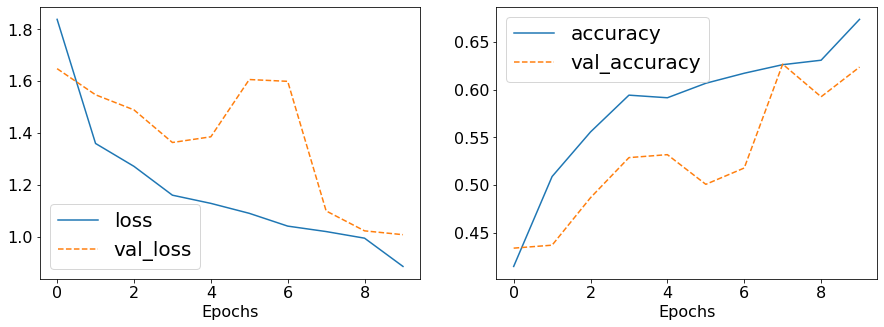

In [40]:

model_multi_hidden = train_and_evaluate_multihidden()

#### Ties paskutinėmis epochomis jau pasiekiamas 60% tikslumas, nors ties 5-6 epochomis atsiranda svyravimas į blogesnę pusę, bet kreivių trendas jau geriau atrodo.

## Pridedamas dropout prie modelio

Model: "clothes_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_pixels (Flatten)      (None, 150528)            0         
                                                                 
 hidden_dense_0 (Dense)      (None, 256)               38535424  
                                                                 
 batchnorm_dense_0 (BatchNor  (None, 256)              512       
 malization)                                                     
                                                                 
 relu_dense_0 (Activation)   (None, 256)               0         
                                                                 
 dropout_dense_0 (Dropout)   (None, 256)               0         
                                                                 
 hidden_dense_1 (Dense)      (None, 64)                16448     
                                            

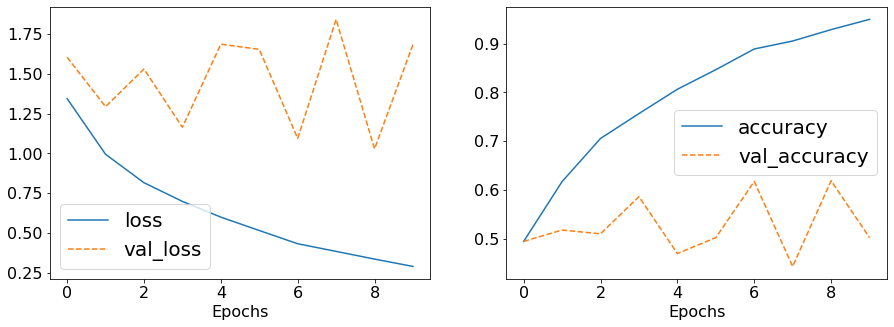

In [41]:
def train_and_evaluate_dropout(lrate = 0.0001,
                       l1 = 0,
                       l2 = 0,
                       dropout_prob = 0.1,
                       num_hidden = [256,64]):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)



  # NN with multiple hidden layers
    layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
    for hno, nodes in enumerate(num_hidden):
        layers.extend([
          tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            name='hidden_dense_{}'.format(hno)),
          tf.keras.layers.BatchNormalization(scale=False, # ReLU
                                         center=False, # have bias in Dense
                                         name='batchnorm_dense_{}'.format(hno)),
          tf.keras.layers.Activation('relu', name='relu_dense_{}'.format(hno)),
          tf.keras.layers.Dropout(rate=dropout_prob,
                             name='dropout_dense_{}'.format(hno)),                         
        ])

    layers.append(
        tf.keras.layers.Dense(len(sar), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='clothes_prob')
  )

    model = tf.keras.Sequential(layers, name='clothes_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)
    training_plot_simple(['loss', 'accuracy'], history)
    return model

model_dropout = train_and_evaluate_dropout()

Model: "clothes_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_pixels (Flatten)      (None, 150528)            0         
                                                                 
 hidden_dense_0 (Dense)      (None, 256)               38535424  
                                                                 
 batchnorm_dense_0 (BatchNor  (None, 256)              512       
 malization)                                                     
                                                                 
 relu_dense_0 (Activation)   (None, 256)               0         
                                                                 
 dropout_dense_0 (Dropout)   (None, 256)               0         
                                                                 
 hidden_dense_1 (Dense)      (None, 64)                16448     
                                            

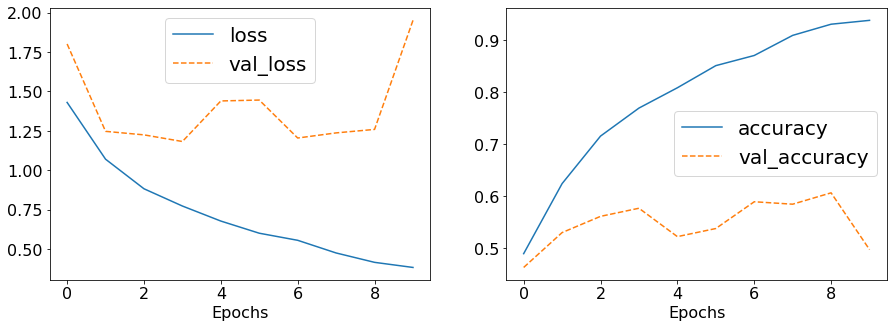

In [42]:
model_dropout = train_and_evaluate_dropout(l2=0.0001)

#### Modeliai vis tiek nėra geri, validation kreivės svyruoja ir turi konstantinį vidurkį, kuris neturi trendo nei kilti, nei leistis. Pabandysiu Convolutional modelį. Naudojamas 2 kartus 3x3 filtras ir 2x2 max pooling operacija

## Convolutional modelis

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 93312)             0         
                                                                 
 dense_9 (Dense)             (None, 128)              

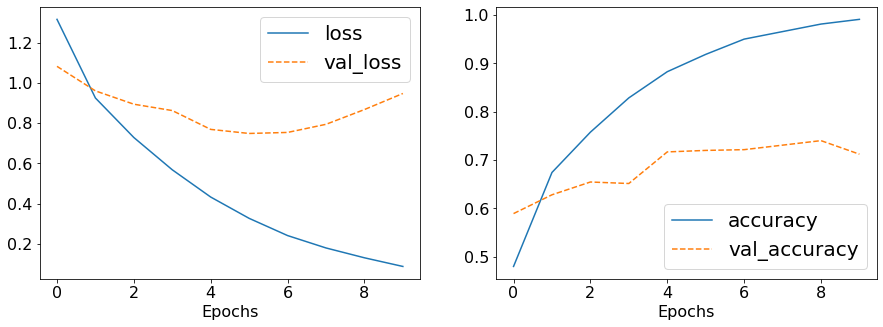

In [43]:

model_conv=Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
    ])

model_conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False), metrics=['accuracy'])

print(model_conv.summary())


history = model_conv.fit(train_dataset, validation_data=test_dataset, epochs=10)
training_plot_simple(['loss', 'accuracy'], history)

#### Convolutional modelis jau visai geras yra, nebesvyruoja tiek daug, nors aukštesnėse epochose validation kreivės ima blogėti. Vall_accuracy pasiekė virš 70% jau su 5 epocha ir toliau tikslumo augimas buvo labai minimalus. Modelį vertinčiau jau kaip pakankamai gerą, lyginant su ankstesniais.

## MobileNet V2 versija

#### MobileNet modeliai jau yra ištreniruoti, jiems mokinti yra naudojami dideli nuotraukų kiekiai, modeliai sudėtingi. Juos apmokyti užtrunka daug laiko ir reikia daug resursų (daug treniruojamų nuotraukų, galingo kompiuterio). Pabandysiu pritaikyti jau ištreniruotą MobileNet modelį šiam drabužių kategorizavimo uždaviniui. Modelis pritaikomas anksčiau jau naudoties duomenims, su 5 skirtingomis drabužių kategorijomis.

In [44]:
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

def train_and_evaluate_mobile(lrate = 0.0005,
                       l1 = 0,
                       l2 = 0.0001,
                       dropout_prob = 0.1,
                       num_hidden = 32):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
        tf.keras.layers.Dropout(rate=dropout_prob,
                             name='dropout_dense'),
      tf.keras.layers.Dense(len(sar), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='clothes_prob')
  ]

    model = tf.keras.Sequential(layers, name='clothes_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=5)
    training_plot_simple(['loss', 'accuracy'], history)
    return model

Model: "clothes_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 32)                40992     
                                                                 
 dropout_dense (Dropout)     (None, 32)                0         
                                                                 
 clothes_prob (Dense)        (None, 10)                330       
                                                                 
Total params: 2,299,306
Trainable params: 41,322
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5
257/257 [==============================] - 83s 306ms/step - loss: 0.6375 - accur

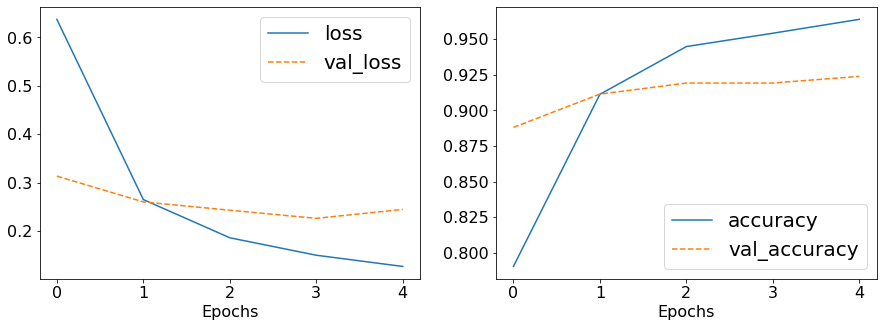

In [64]:
model_mobile = train_and_evaluate_mobile()

Model: "clothes_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 32)                40992     
                                                                 
 dropout_dense (Dropout)     (None, 32)                0         
                                                                 
 clothes_prob (Dense)        (None, 10)                330       
                                                                 
Total params: 2,299,306
Trainable params: 41,322
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5
257/257 [==============================] - 92s 320ms/step - loss: 0.6222 - accur

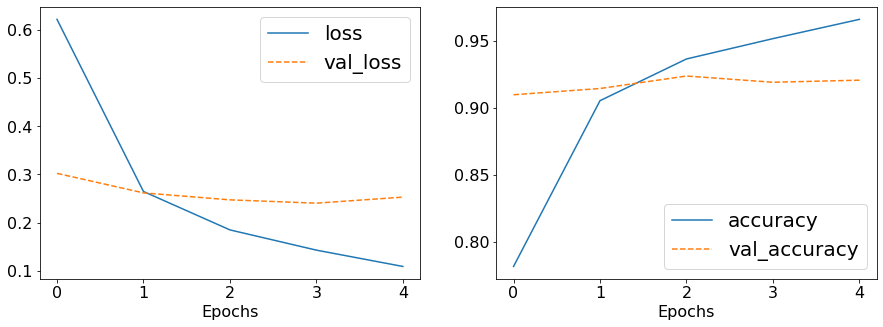

In [65]:
model_mobile = train_and_evaluate_mobile(l2=0)

#### Mobile Net V2 modelio tikslumas ties paskutine epocha yra virš 92%, tai yra daug geresnis rezultatas, nei tada, kai yra kuriamas modelis nuo pradžių. Tokie jau ištreniruoti modeliai yra labiau tikslesni, nes yra apmokomi su dideliais duomenų kiekiais. Geresnis rezultatas yra, kai L2=0.0001. L2=0 atveju ties 4 epocha rezultatas šiek tiek pablogėja.

## MobileNet V3 modelis

In [66]:
def train_and_evaluate_mobilev3(train_dataset, test_dataset,
                       lrate = 0.0005,
                       l1 = 0,
                       l2 = 0.0001,
                       dropout_prob = 0.1,
                       num_hidden = 32):
    
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
        tf.keras.layers.Dropout(rate=dropout_prob,
                             name='dropout_dense'),
      tf.keras.layers.Dense(len(sar), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='clothes_prob')
        
  ]

    model = tf.keras.Sequential(layers, name='clothes_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=5)
    training_plot_simple(['loss', 'accuracy'], history)
    return model

Model: "clothes_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             4226432   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 32)                40992     
                                                                 
 dropout_dense (Dropout)     (None, 32)                0         
                                                                 
 clothes_prob (Dense)        (None, 10)                330       
                                                                 
Total params: 4,267,754
Trainable params: 41,322
Non-trainable params: 4,226,432
_________________________________________________________________
None
Epoch 1/5
257/257 [==============================] - 84s 312ms/step - loss: 0.5018 - accur

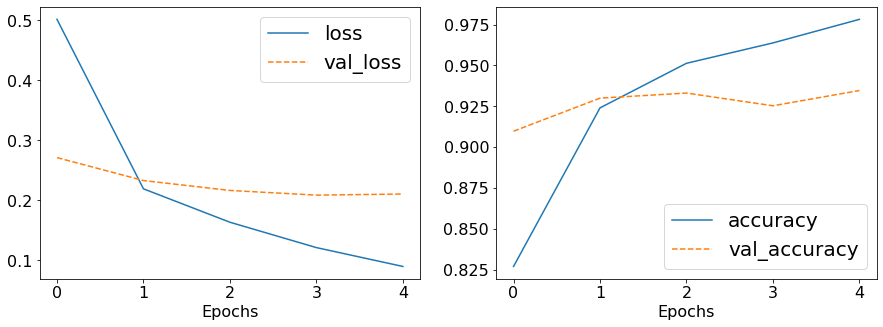

In [67]:
model_mobilev3 = train_and_evaluate_mobilev3( train_dataset=train_dataset, test_dataset=test_dataset)

### V3 modelio tikslumas po 5 epochų daugiau, nei 93%, nors ir yra nedidelis svyravimas Val_accuracy kreivėje.  Nors ir labai nežymiai, bet šis modelis yra geresnis už V2.  Renkuosi Mobile Net V3, kaip geriausią modelį. Jį panaudosiu ir pridėjusi daugiau drabužių kategorijų. 

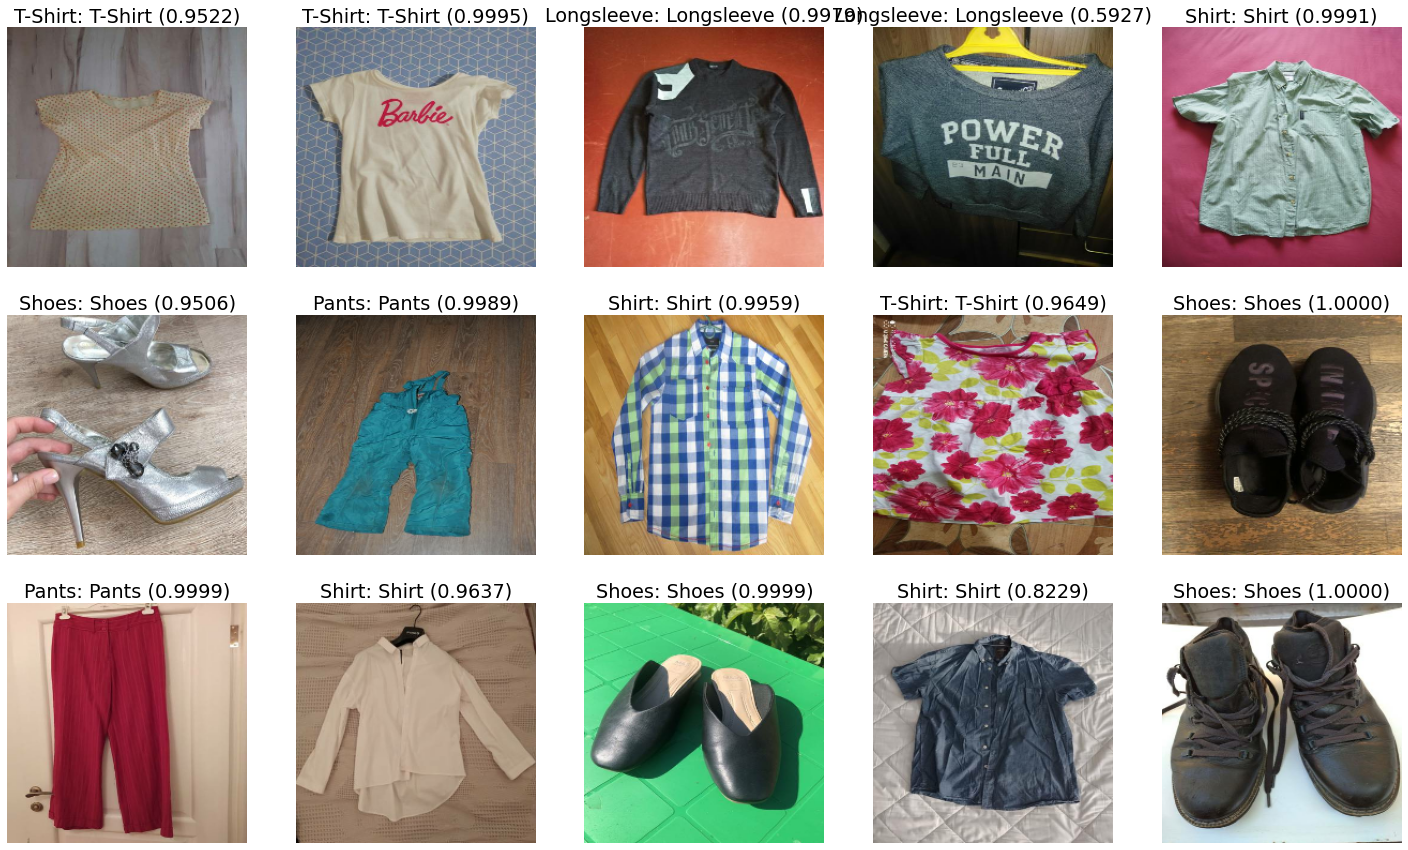

In [69]:
plot_predictions(model_mobilev3, "test.csv")

#### Iš 15 pavaizduotų nuotraukų, Mobile Net V3 modelis visas sukategorizavo teisingai.

# Pridėsiu daugiau kategorijų treniravimui ir tada pažiūrėsiu ar modelio tikslumas labai keičiasi.

In [50]:
data_new.label.value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Top             43
Blouse          23
Name: label, dtype: int64

In [51]:
sar=["T-Shirt", "Longsleeve", "Pants", "Shoes", "Shirt", "Dress", "Outwear", "Shorts", "Hat", "Skirt"]
len(sar)

10

In [52]:
small_data10=data_new.loc[data_new.label.isin(sar)] #4514 nuotraukų
small_data10

index                                 image  sender_id    label   kids  \
0         1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148  T-Shirt  False   
1         3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43  T-Shirt  False   
2         4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189    Shoes  False   
3         5  5d3a1404-697f-479f-9090-c1ecd0413d27        138   Shorts  False   
4         6  b0c03127-9dfb-4573-8934-1958396937bf        138    Shirt  False   
...     ...                                   ...        ...      ...    ...   
5090   5397  3855ea22-5e7f-411f-b1fa-6db27a676c06        204    Shoes   True   
5091   5398  dfd4079d-967b-4b3e-8574-fbac11b58103        204   Shorts  False   
5093   5400  5379356a-40ee-4890-b416-2336a7d84061        310   Shorts  False   
5094   5401  65507fb8-3456-4c15-b53e-d1b03bf71a59        204    Shoes  False   
5095   5402  32b99302-cec7-4dec-adfa-3d4029674209        204    Skirt  False   

                                                photo  
0     images/ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg  
1     images/ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg  
2     images/3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg  
3     images/5d3a1404-697f-479f-9090-c1ecd0413d27.jpg  
4     images/b0c03127-9dfb-4573-8934-1958396937bf.jpg  
...                                               ...  
5090  images/3855ea22-5e7f-411f-b1fa-6db27a676c06.jpg  
5091  images/dfd4079d-967b-4b3e-8574-fbac11b58103.jpg  
5093  images/5379356a-40ee-4890-b416-2336a7d84061.jpg  
5094  images/65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg  
5095  images/32b99302-cec7-4dec-adfa-3d4029674209.jpg  

[4514 rows x 6 columns]

In [53]:
sd10=small_data10[["photo", "label"]]
sd10

photo    label
0     images/ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg  T-Shirt
1     images/ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg  T-Shirt
2     images/3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg    Shoes
3     images/5d3a1404-697f-479f-9090-c1ecd0413d27.jpg   Shorts
4     images/b0c03127-9dfb-4573-8934-1958396937bf.jpg    Shirt
...                                               ...      ...
5090  images/3855ea22-5e7f-411f-b1fa-6db27a676c06.jpg    Shoes
5091  images/dfd4079d-967b-4b3e-8574-fbac11b58103.jpg   Shorts
5093  images/5379356a-40ee-4890-b416-2336a7d84061.jpg   Shorts
5094  images/65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg    Shoes
5095  images/32b99302-cec7-4dec-adfa-3d4029674209.jpg    Skirt

[4514 rows x 2 columns]

In [54]:
train, test = train_test_split(sd10, test_size=0.2, random_state=100)

In [55]:
train.to_csv('train10.csv', index=False, header=False) 
test.to_csv('test10.csv', index=False, header=False)

In [56]:
train_dataset10 = (tf.data.TextLineDataset(
    "train10.csv").map(decode_csv)).batch(15)

test_dataset10 = (tf.data.TextLineDataset(
    "test10.csv").map(decode_csv)).batch(15)

Model: "clothes_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             4226432   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 32)                40992     
                                                                 
 dropout_dense (Dropout)     (None, 32)                0         
                                                                 
 clothes_prob (Dense)        (None, 10)                330       
                                                                 
Total params: 4,267,754
Trainable params: 41,322
Non-trainable params: 4,226,432
_________________________________________________________________
None
Epoch 1/5
241/241 [==============================] - 108s 433ms/step - loss: 1.0494 - accu

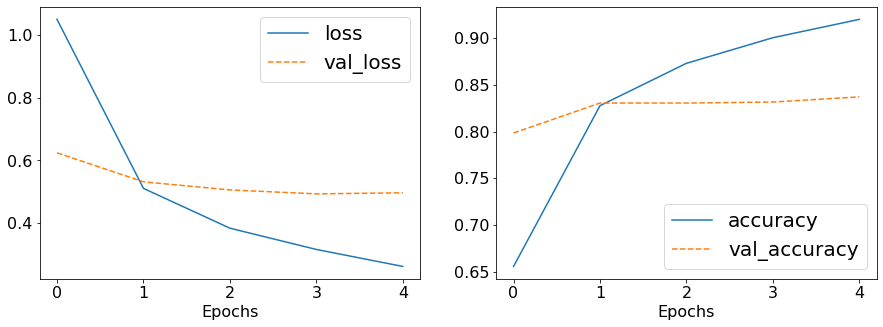

In [70]:
model_mobilev3_10 = train_and_evaluate_mobilev3(l2=0.0001, train_dataset=train_dataset10, test_dataset=test_dataset10)


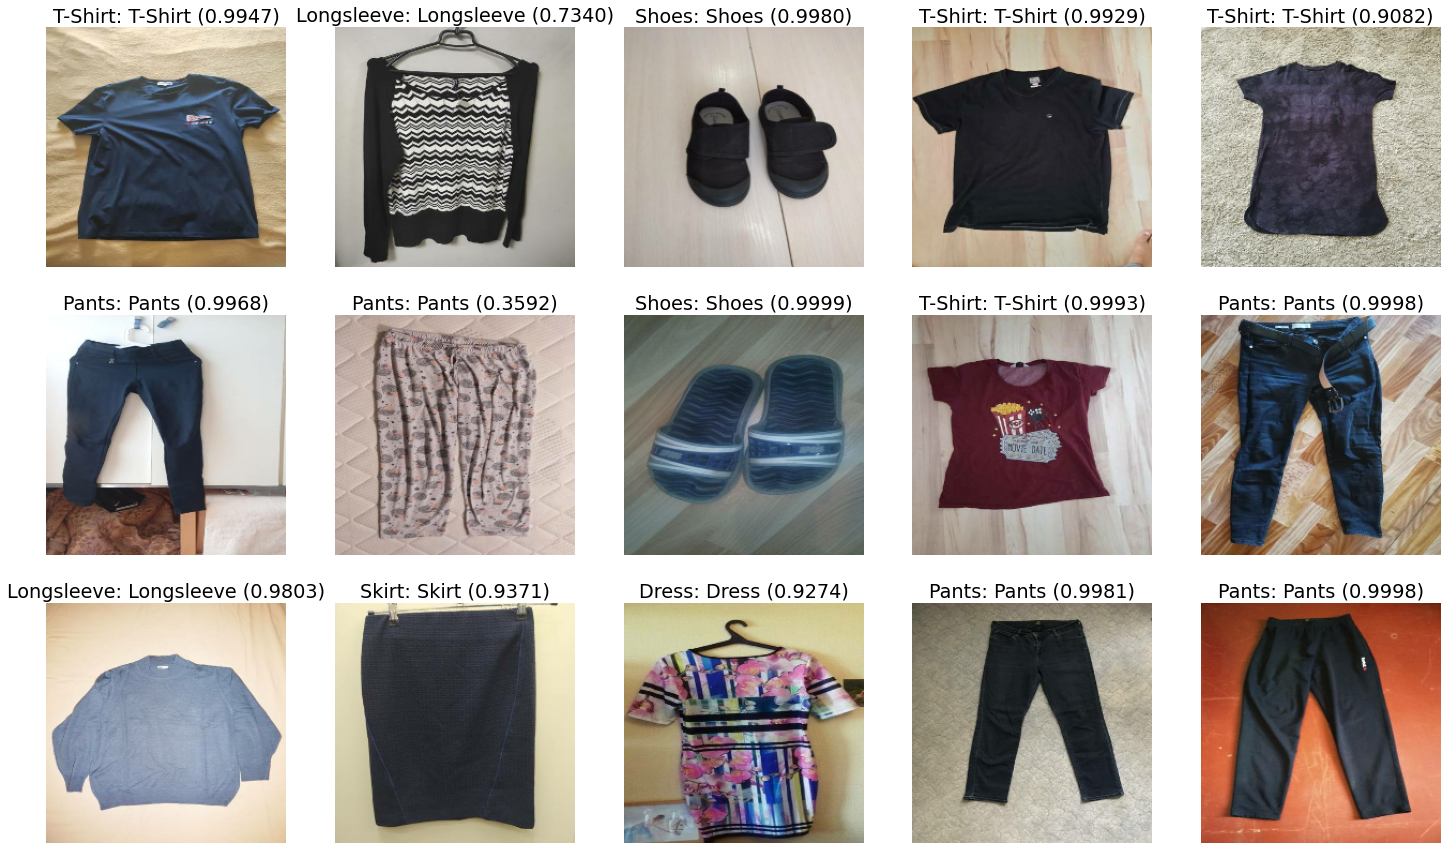

In [71]:
plot_predictions(model_mobilev3_10, "test10.csv")

#### Šiuo atveju su 10 kategorijų, modelio tikslumas yra mažesnis, šiek tiek mažiau nei 84%. Iš nuotraukų galime matyti, kad visi drabužiai yra suklasifikuoti teisingai. Modelio tikslumas su daugiau duomenų sumažėjo, bet vis tiek yra gana didelis.

## Modelio išsaugojimas

In [72]:
import os
model_mobilev3_10.save('clothes_model')

INFO:tensorflow:Assets written to: clothes_model\assets


INFO:tensorflow:Assets written to: clothes_model\assets


In [73]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir clothes_model

The given SavedModel SignatureDef contains the following input(s):

2022-05-14 14:35:19.170191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-14 14:35:19.172027: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



  inputs['mobilenet_embedding_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_mobilenet_embedding_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['clothes_prob'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


## Drabužių kategorijos prognozavimas

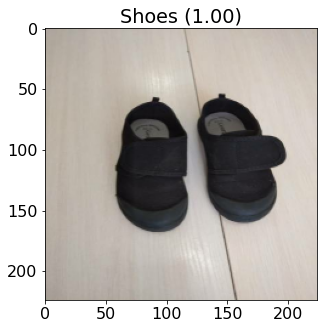

In [74]:
filenames = [
    'images/ebb7b9bb-bae5-4865-88c1-3940b7456f40.jpg'
]

img = read_and_decode(filenames[0], [224,224])
                              
serving_model = tf.keras.models.load_model('clothes_model')
input_images = [create_preproc_image(f) for f in filenames]
#print(input_images)
f, ax = plt.subplots(1, len(filenames), figsize=(5,5))
plt.imshow((img.numpy()));
batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
batch_pred = serving_model.predict(batch_image)
pred = batch_pred[0]
pred_label_index = tf.math.argmax(pred).numpy()
pred_label = sar[pred_label_index]
prob = pred[pred_label_index]
ax.set_title('{} ({:.2f})'.format(pred_label, prob));

